# Neural Network for ECG Classification



single lead ecg ml 


#### IMPORTS

In [ ]:
import torch
import numpy as np


from dataloader import MyCustomDataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
default_dir = os.getcwd()
def default_directory():
    os.chdir(f"{default_dir}")
    print(f"you are back to the default directory: {default_dir}")


In [3]:
default_directory()
os.getcwd()

you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN


'/home/karansingh/Documents/summer-term/ECG_ML/MAIN'

In [4]:
os.chdir("../../KARAN_ECG/data_prep")
os.getcwd()

'/home/karansingh/Documents/summer-term/KARAN_ECG/data_prep'

In [5]:
# get list of all files in the directory
files = os.listdir()
print(files)

['disease_ST_random.npy', 'README', 'del.ipynb', 'disease_SB.npy', 'data_prep.ipynb', 'disease_SB_random.npy', 'unq_disease_SR.npy', 'unq_disease_SB_random.npy', 'unq_disease_ST.npy', 'unq_disease_SR_random.npy', 'data_prep_for_only_one_disease.ipynb', 'unq_disease_ST_random.npy', 'disease_SR.npy', 'disease_ST.npy', 'unq_disease_SB.npy', 'disease_SR_random.npy', 'data']


#### LOAD DATA

In [6]:
#import disease_SB_random.npy , disease_ST_random.npy, disease_SR_random.npy
data_ST_list = np.load("disease_ST_random.npy")
data_SB_list = np.load("disease_SB_random.npy")
data_SR_list = np.load("disease_SR_random.npy")
#print shape of all loaded files
print("shape of ST data: ", data_ST_list.shape)
print("shape of SB data: ", data_SB_list.shape)
print("shape of SR data: ", data_SR_list.shape)



shape of ST data:  (5000, 5000, 12)
shape of SB data:  (5000, 5000, 12)
shape of SR data:  (5000, 5000, 12)


### for lead 1


In [7]:
## Create fake dataset for demonstration purposes

## Load your dataset and use 
# lead 1
images = data_ST_list[:,:,0]

labels=np.zeros(5000)

#SB
images = np.concatenate((images,data_SB_list[:,:,0]))
labels=np.concatenate((labels,np.ones(5000)))

#SR
images = np.concatenate((images,data_SR_list[:,:,0]))
labels=np.concatenate((labels,2*np.ones(5000)))

print("we have ", images.shape[0], " images and ", labels.shape[0], " labels")
                    

we have  15000  images and  15000  labels


In [8]:
len(images),len(labels)

(15000, 15000)

#### CREATE BATCHES

In [9]:
# Create an instance of your dataset
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = MyCustomDataset(images_train, labels_train)
test_dataset = MyCustomDataset(images_test, labels_test)
# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## model


In [13]:
class Model(nn.Module):
    """Base model with 5 layers"""
    def __init__(self, in_features=5000, h1=1000, h2=250,
                 h3=100, h4=30, h5=10,
                 out_features=3):
        """Initialize an instance of the model"""
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, out_features)

    def forward(self, x):
        """Forward method for the layers in the model"""
        # Using softmax in the output layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        return x


#### TRAINING PARAMETERS

In [14]:
torch.manual_seed(37)  # Set seed for reproducibility
model__ = Model()

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model__.parameters(), lr=0.001)  # Adam optimizer
def accuracy(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


#### TRAINING

In [15]:
import torch.nn.functional as F
torch.manual_seed(21)  # Set seed for reproducibility
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model__ = Model().to(device)

criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model__.parameters(), lr=0.001)  # Adam optimizer

def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

num_epochs = 25
test_losses_list = []
train_losses_list = []
accuracy_train_list = []
accuracy_test_list = []

for epoch in range(num_epochs):
    model__.train()
    running_loss, accuracy_train = 0.0, 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model__(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        accuracy_train += accuracy(labels, outputs.argmax(dim=1))
    train_losses_list.append(running_loss / len(train_dataloader))
    
    # Just calculating the test loss and accuracy
    with torch.no_grad():
        model__.eval()
        test_loss, accuracy_test = 0.0, 0.0
        for i, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model__(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            accuracy_test += accuracy(labels, outputs.argmax(dim=1))
    test_losses_list.append(test_loss / len(test_dataloader))
    
    accuracy_train_list.append(accuracy_train / len(train_dataloader))
    accuracy_test_list.append(accuracy_test / len(test_dataloader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}, Train Accuracy: {accuracy_train / len(train_dataloader):.4f}, Test Accuracy: {accuracy_test / len(test_dataloader):.4f}')

Epoch [1/25], Train Loss: 0.8896, Test Loss: 0.7167, Train Accuracy: 56.9167, Test Accuracy: 71.5204
Epoch [2/25], Train Loss: 0.5421, Test Loss: 0.5817, Train Accuracy: 77.9917, Test Accuracy: 76.8395
Epoch [3/25], Train Loss: 0.3521, Test Loss: 0.5929, Train Accuracy: 87.0250, Test Accuracy: 78.2137
Epoch [4/25], Train Loss: 0.2290, Test Loss: 0.6390, Train Accuracy: 91.5333, Test Accuracy: 78.6569
Epoch [5/25], Train Loss: 0.1807, Test Loss: 0.7878, Train Accuracy: 93.3750, Test Accuracy: 78.6126
Epoch [6/25], Train Loss: 0.1496, Test Loss: 0.8092, Train Accuracy: 94.5500, Test Accuracy: 79.6875
Epoch [7/25], Train Loss: 0.1194, Test Loss: 0.7943, Train Accuracy: 95.6917, Test Accuracy: 79.1002
Epoch [8/25], Train Loss: 0.0940, Test Loss: 1.1025, Train Accuracy: 96.7250, Test Accuracy: 79.4770
Epoch [9/25], Train Loss: 0.0988, Test Loss: 1.1152, Train Accuracy: 96.4750, Test Accuracy: 78.8785
Epoch [10/25], Train Loss: 0.0776, Test Loss: 1.3358, Train Accuracy: 97.2917, Test Accurac

In [16]:
# save the model
#default_directory()
#torch.save(model__.state_dict(), 'model_v0.pth')



you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN


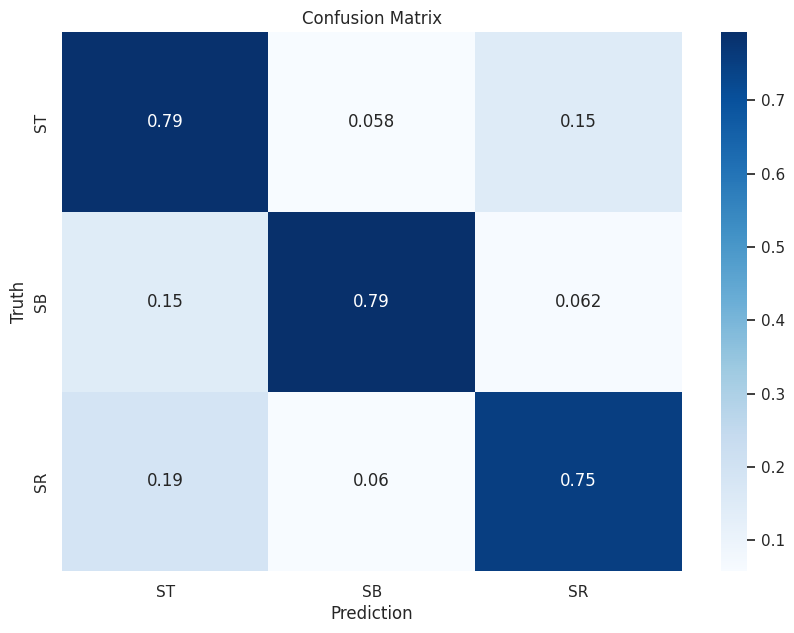

In [33]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

model__.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model__(images.to(device))
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
df_cm = pd.DataFrame(cm, index=["ST", "SB", "SR"], columns=["ST", "SB", "SR"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()




In [18]:

#Classification Report for Test Data:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["ST", "SB", "SR"]))


              precision    recall  f1-score   support

          ST       0.71      0.79      0.75      1037
          SB       0.87      0.79      0.83       970
          SR       0.77      0.75      0.76       993

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



Average precision score, micro-averaged over all classes: 0.68


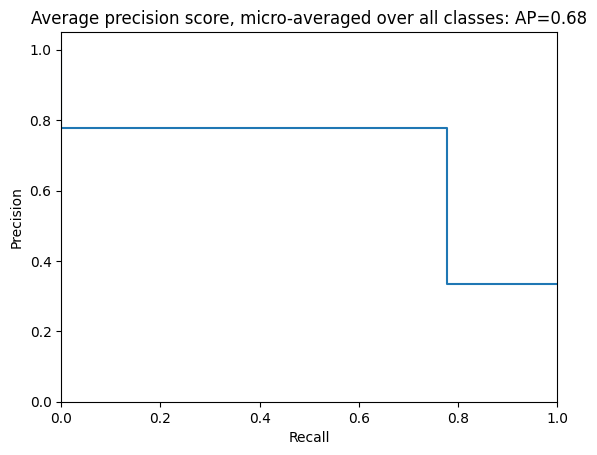

In [19]:
# presicion recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve((np.array(y_true) == i).astype(int),
                                                        (np.array(y_pred) == i).astype(int))
    average_precision[i] = average_precision_score((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(np.eye(3)[y_true].ravel(),
    np.eye(3)[y_pred].ravel())
average_precision["micro"] = average_precision_score(np.eye(3)[y_true], np.eye(3)[y_pred],
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.show()

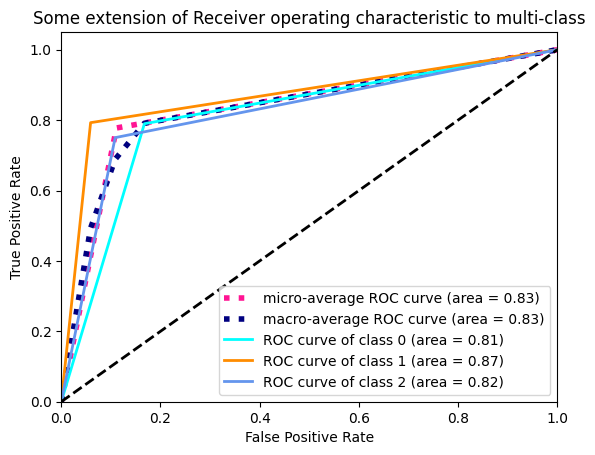

In [20]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_score = label_binarize(y_pred, classes=[0, 1, 2])


n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



you are back to the default directory: /home/karansingh/Documents/summer-term/ECG_ML/MAIN


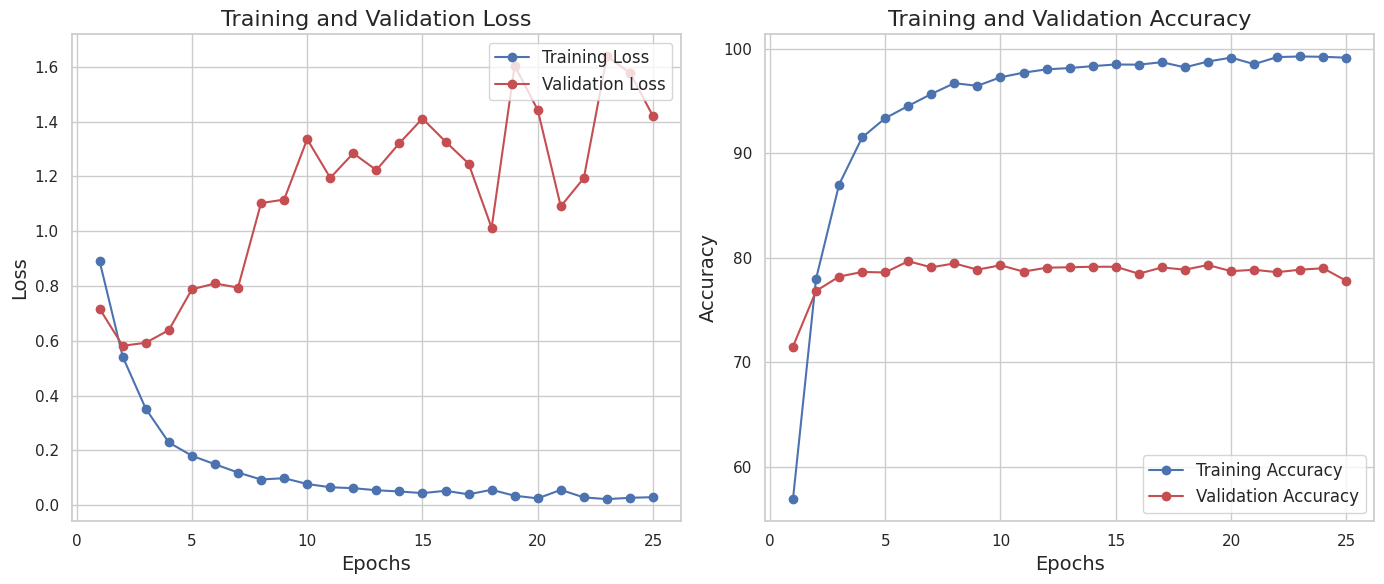

In [21]:
default_directory()
from plots import accuracy_and_validation_plots


# Example data: Replace these with your actual training and validation data
epochs_= list(range(1, len(train_losses_list)+1))

accuracy_and_validation_plots(epochs_, train_losses_list, test_losses_list, accuracy_train_list,accuracy_test_list).plot_figure("accuracy.png")


In [22]:
def model_train(train_dataloader, test_dataloader,n):
    torch.manual_seed(n)  # Set seed for reproducibility
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model__ = Model().to(device)

    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.Adam(model__.parameters(), lr=0.001)  # Adam optimizer

    def accuracy(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

    num_epochs = 25
    test_losses_list = []
    train_losses_list = []
    accuracy_train_list = []
    accuracy_test_list = []

    for epoch in range(num_epochs):
        model__.train()
        running_loss, accuracy_train = 0.0, 0.0
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model__(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            accuracy_train += accuracy(labels, outputs.argmax(dim=1))
        train_losses_list.append(running_loss / len(train_dataloader))
        
        # Just calculating the test loss and accuracy
        with torch.no_grad():
            model__.eval()
            test_loss, accuracy_test = 0.0, 0.0
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                outputs = model__(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                accuracy_test += accuracy(labels, outputs.argmax(dim=1))
        test_losses_list.append(test_loss / len(test_dataloader))
        
        accuracy_train_list.append(accuracy_train / len(train_dataloader))
        accuracy_test_list.append(accuracy_test / len(test_dataloader))

        #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}, Train Accuracy: {accuracy_train / len(train_dataloader):.4f}, Test Accuracy: {accuracy_test / len(test_dataloader):.4f}')
    return train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list

## image

In [23]:
# open accuracy_seed_test.npy
accuracy_seed_test = np.load("accuracy_seed_test.npy").tolist()
accuracy_seed_train = np.load("accuracy_seed_train.npy").tolist()

In [24]:
# find the seed with minimum mse btw train and test
mse_list = []
for i in range(0, 60):
    mse = np.mean((np.array(accuracy_seed_train[i]) - np.array(accuracy_seed_test[i]))**2)
    mse_list.append(mse)
min_seed = np.argmin(mse_list)
print(f"Seed with minimum MSE between train and test: {min_seed}")


Seed with minimum MSE between train and test: 33


## test


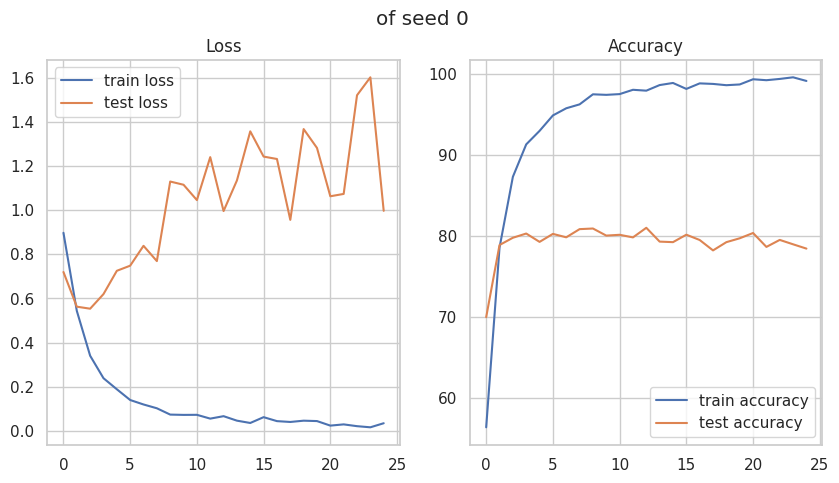

78.4020390070922


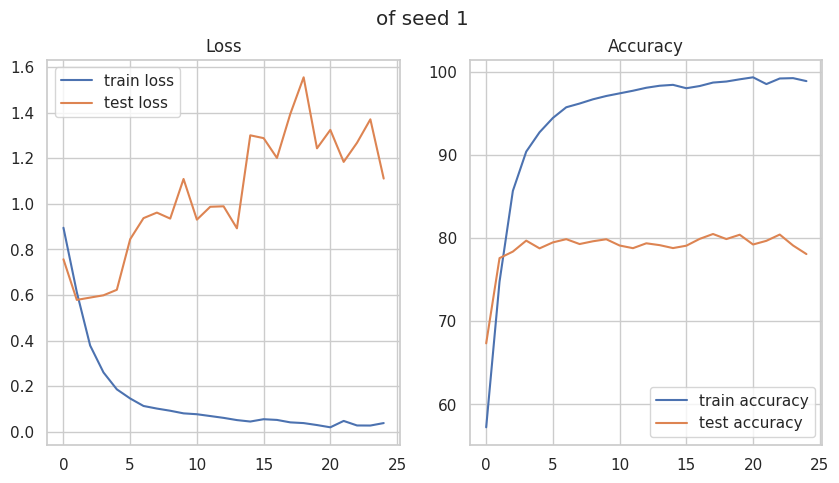

78.09175531914893


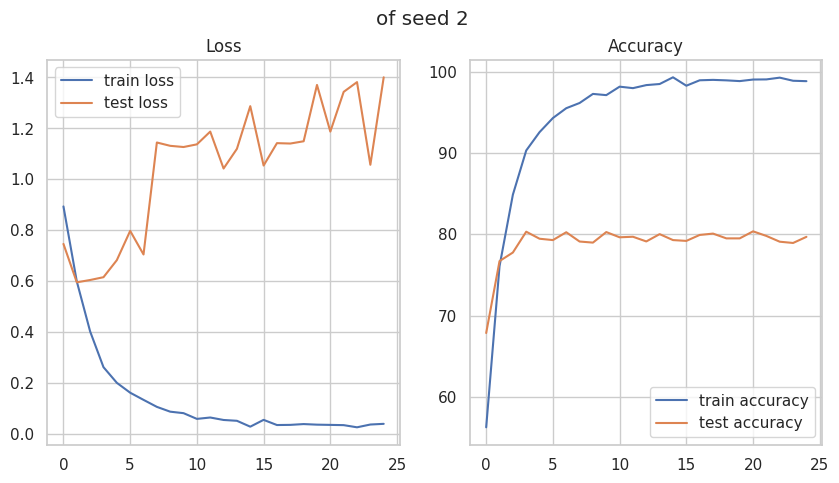

79.67641843971631


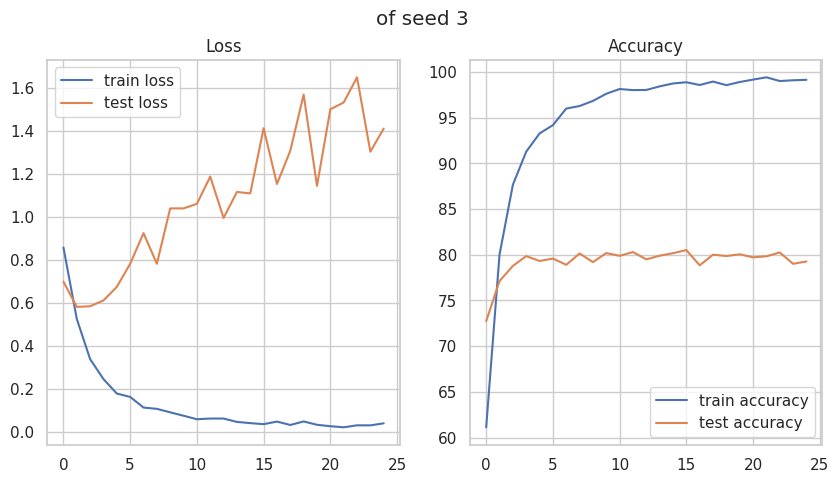

79.26640070921987


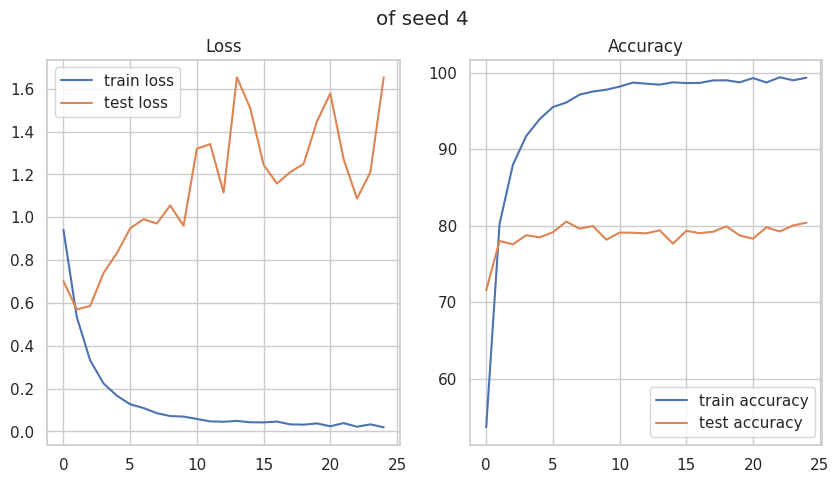

80.38563829787235


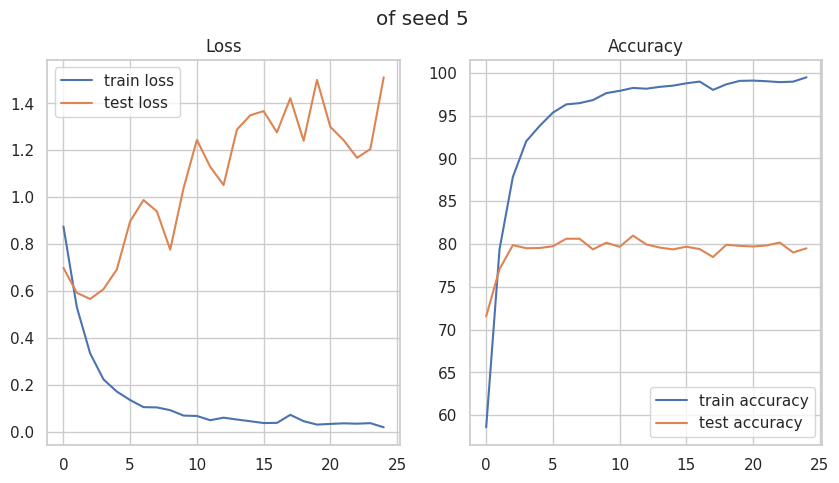

79.49911347517731


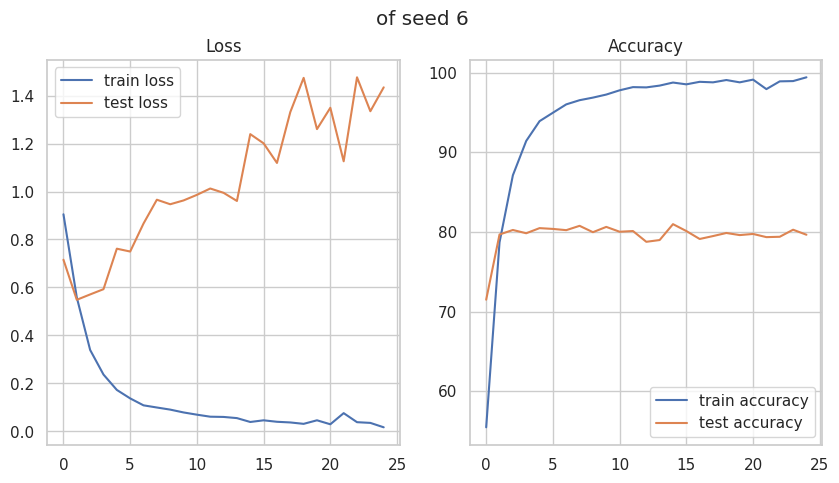

79.64317375886525


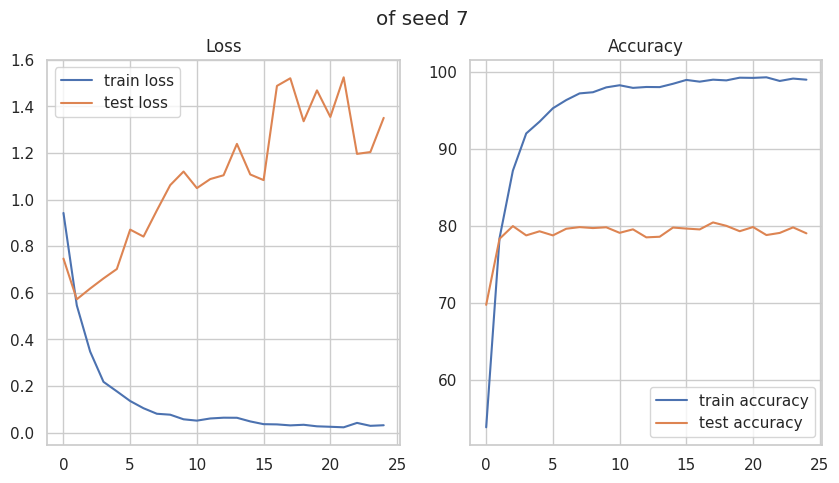

79.01152482269504


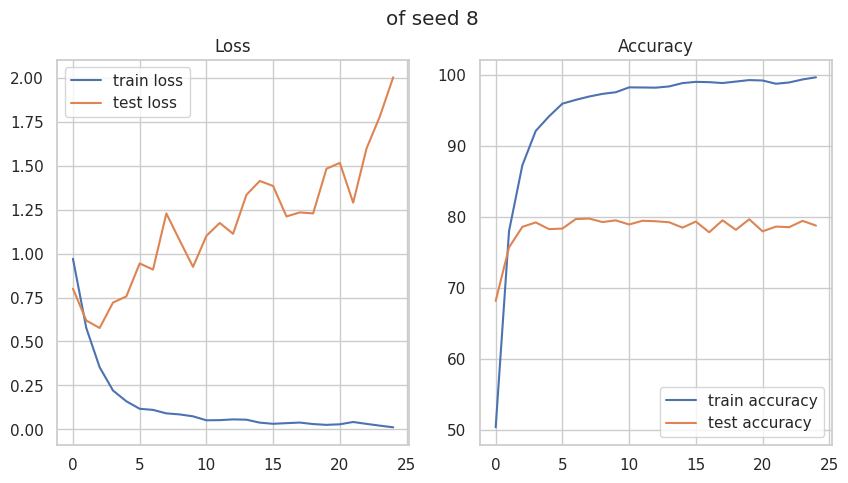

78.81205673758865


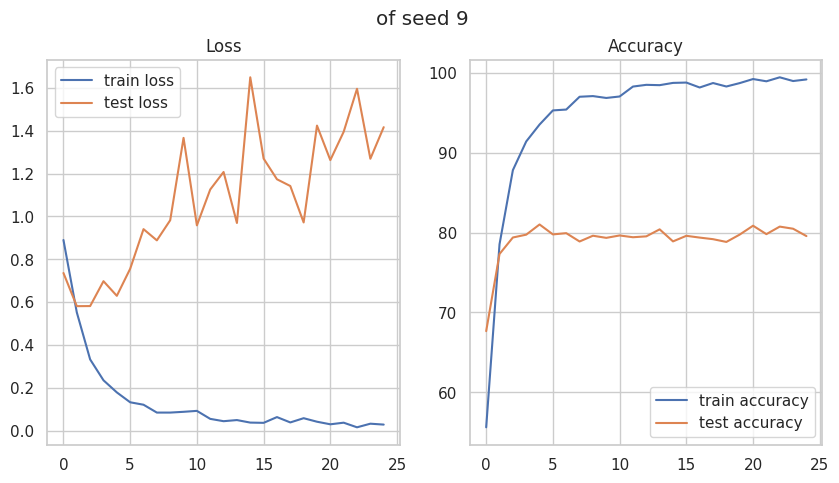

79.55452127659575


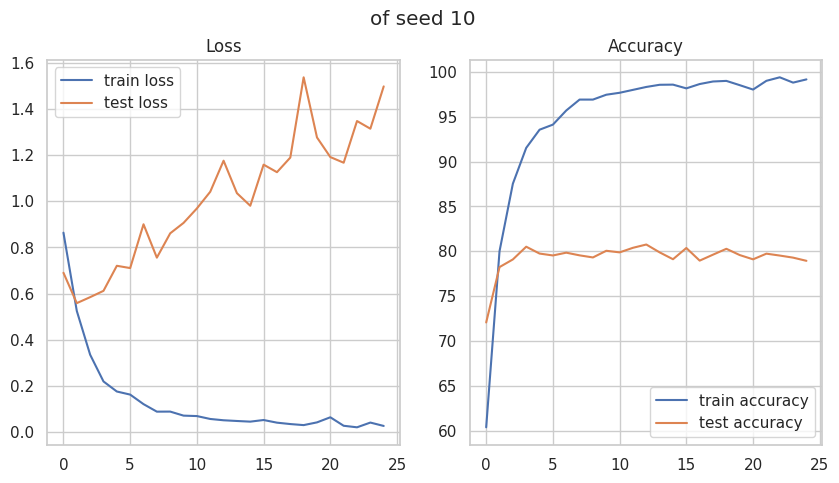

78.93395390070923


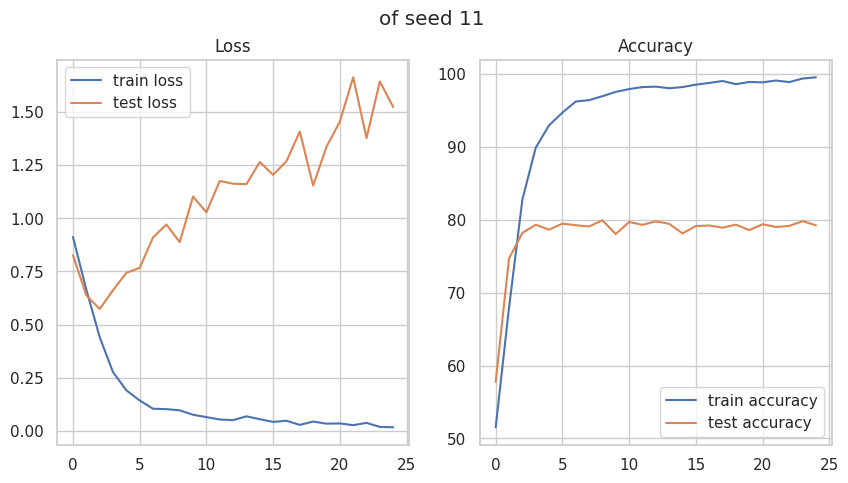

79.25531914893617


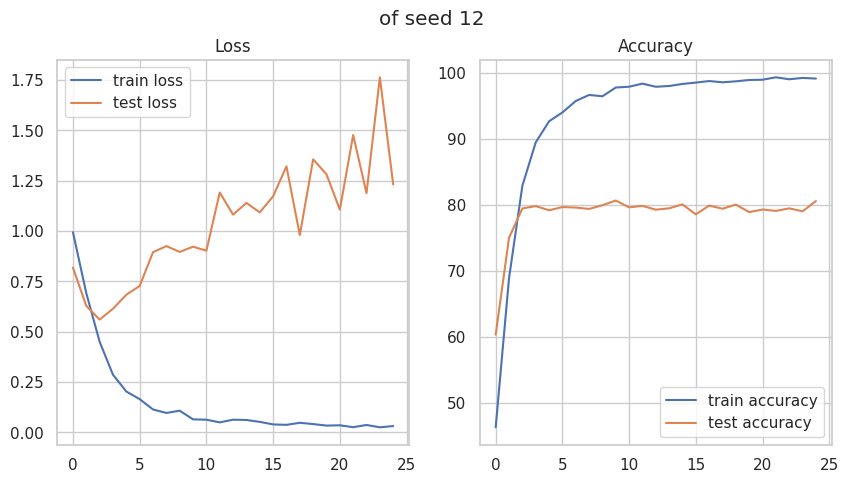

80.58510638297872


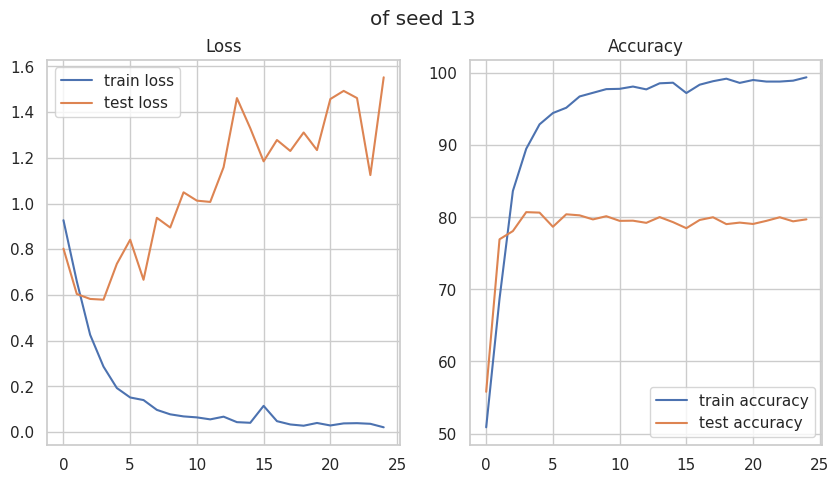

79.72074468085107


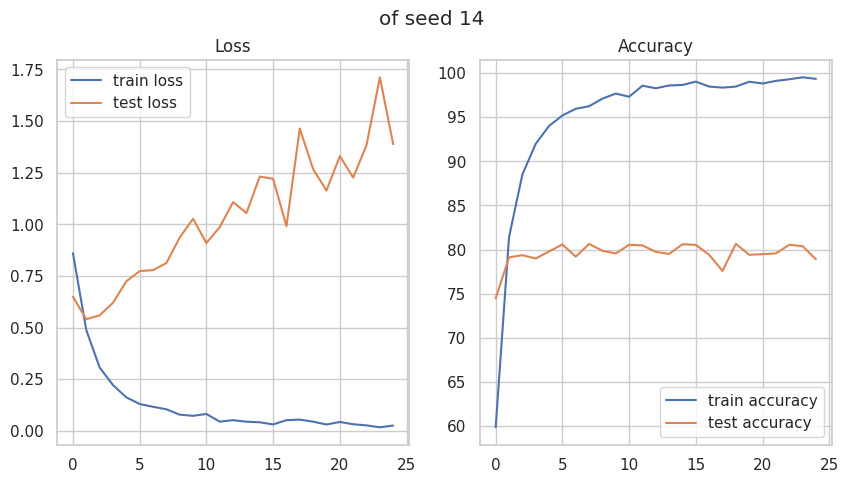

78.88962765957447


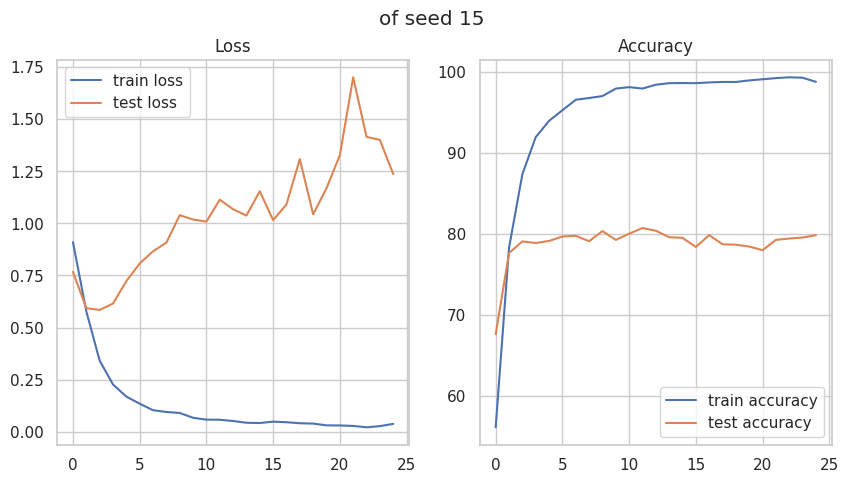

79.84264184397163


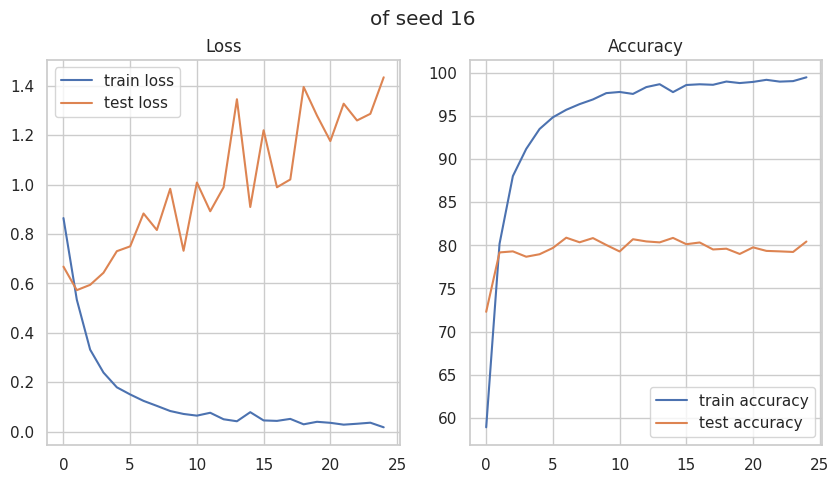

80.44104609929077


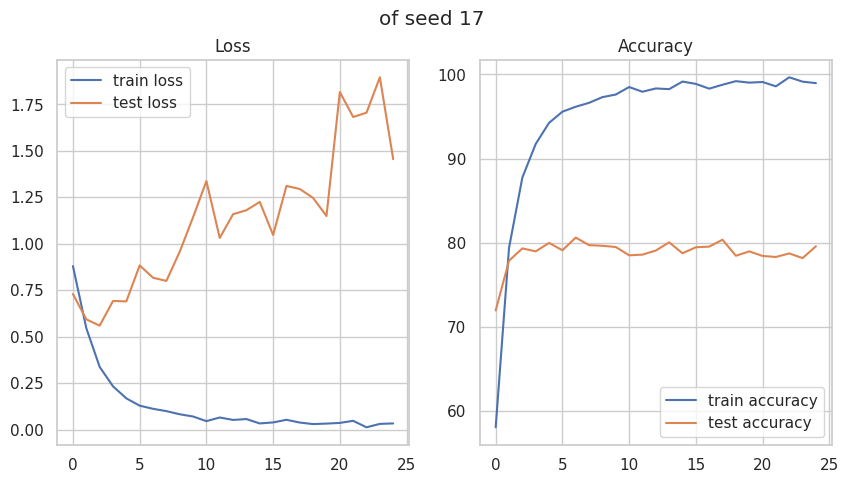

79.56560283687944


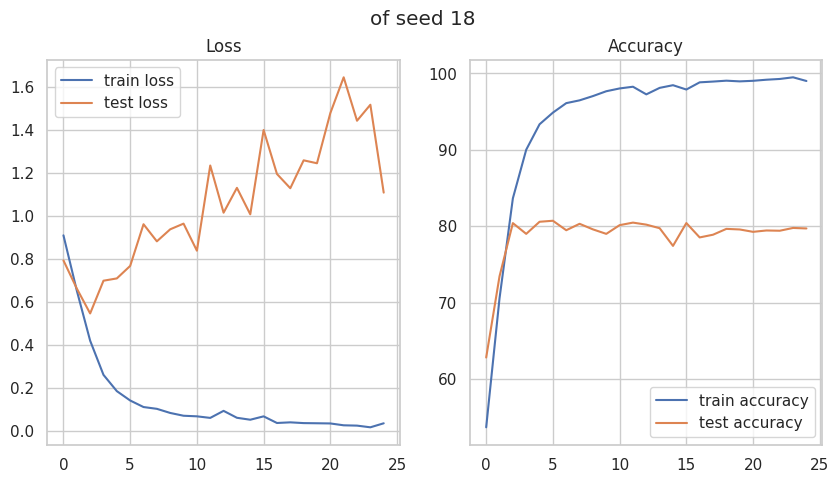

79.69858156028369


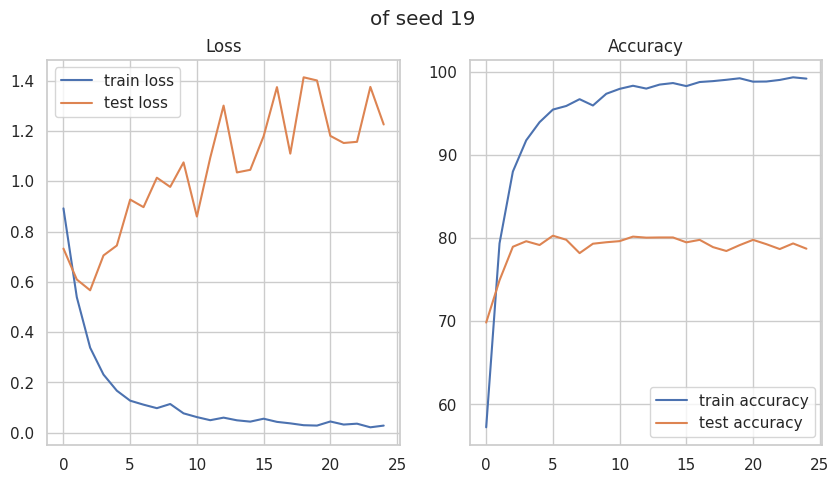

78.73448581560284


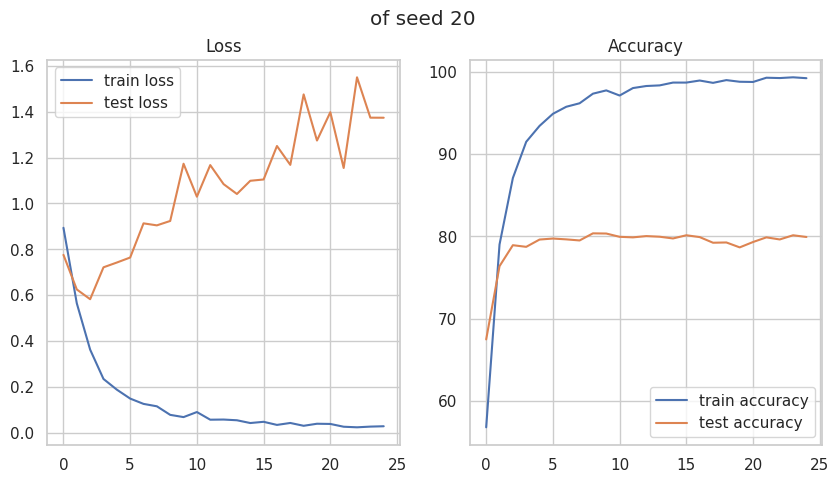

79.92021276595744


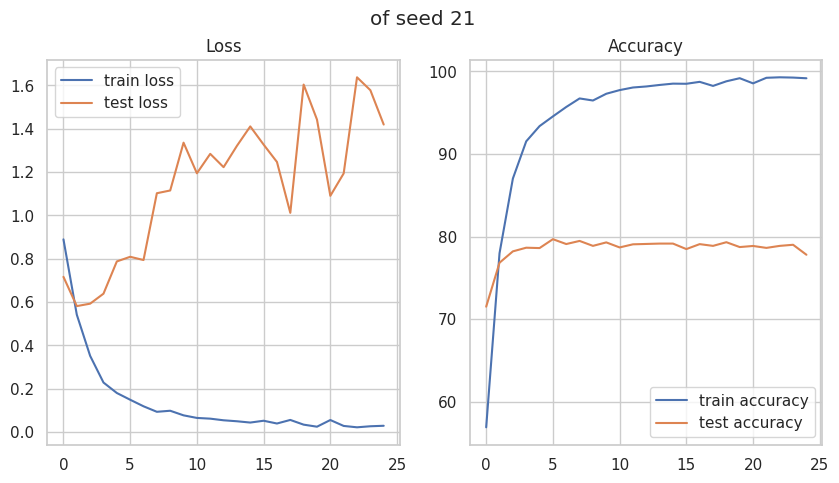

77.80363475177305


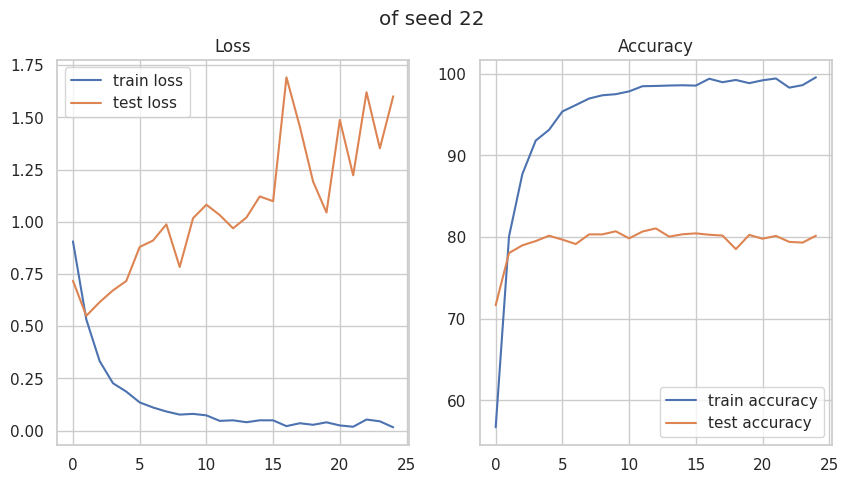

80.16400709219859


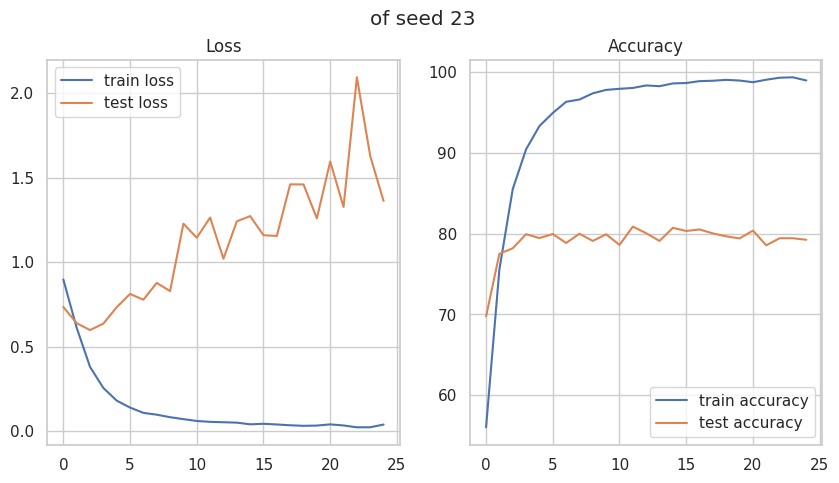

79.2331560283688


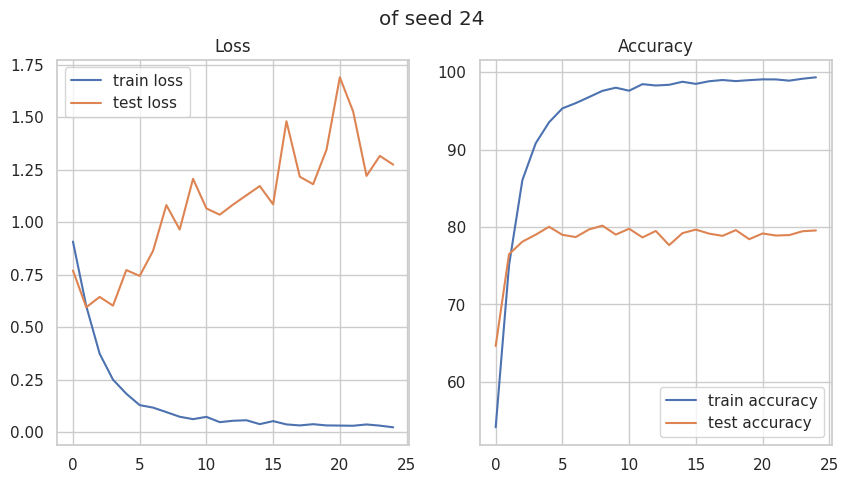

79.54343971631205


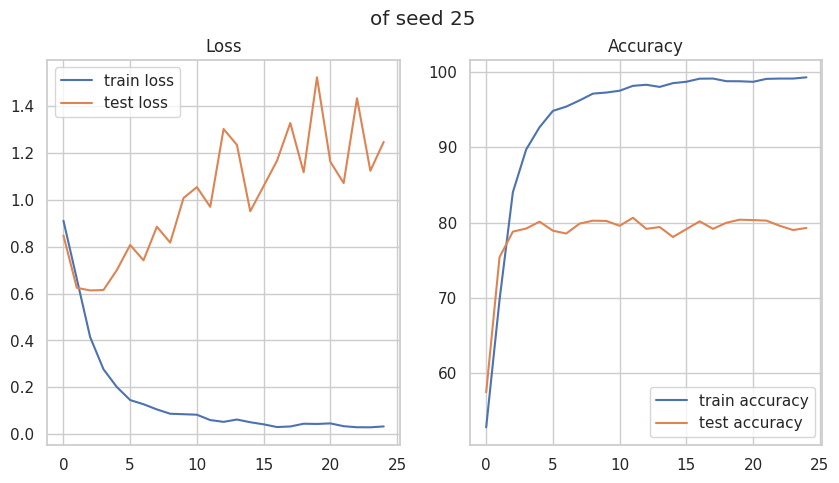

79.27748226950354


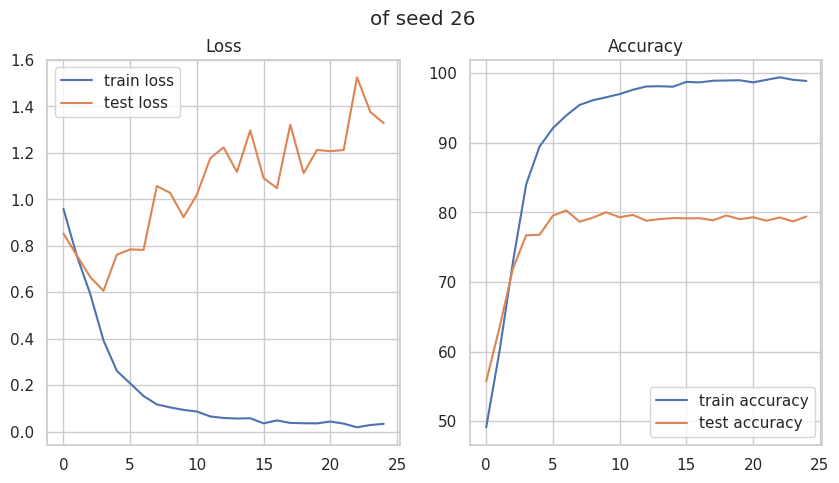

79.42154255319149


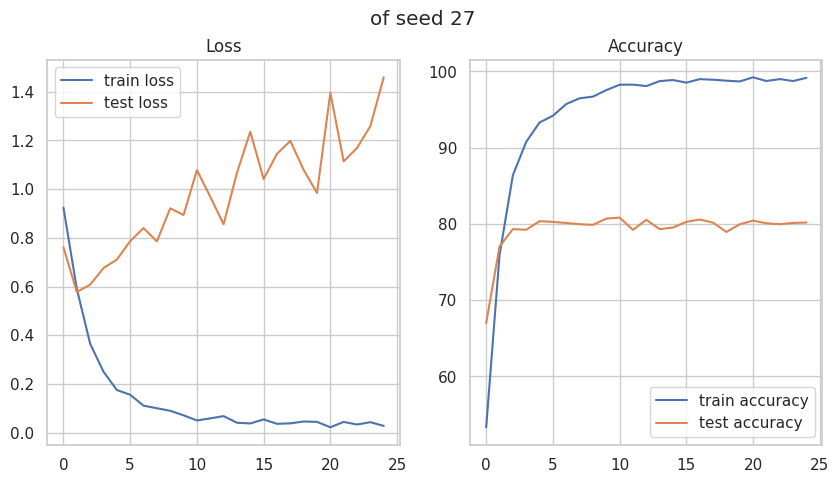

80.17508865248227


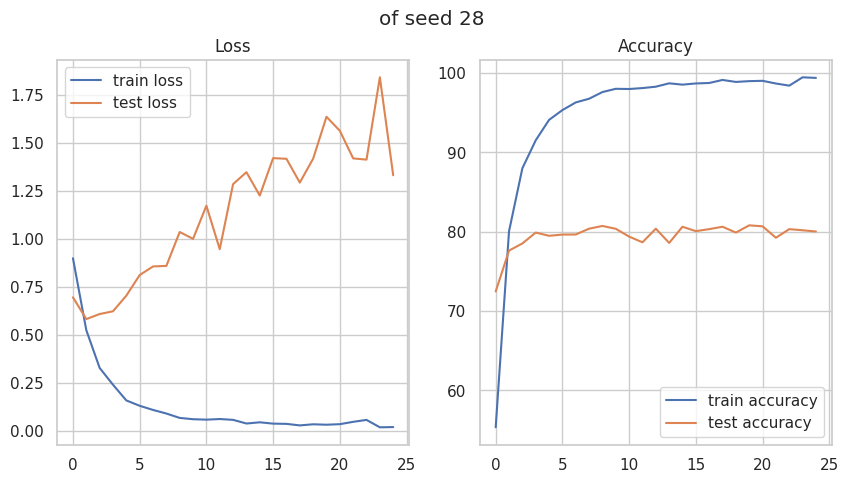

80.03102836879432


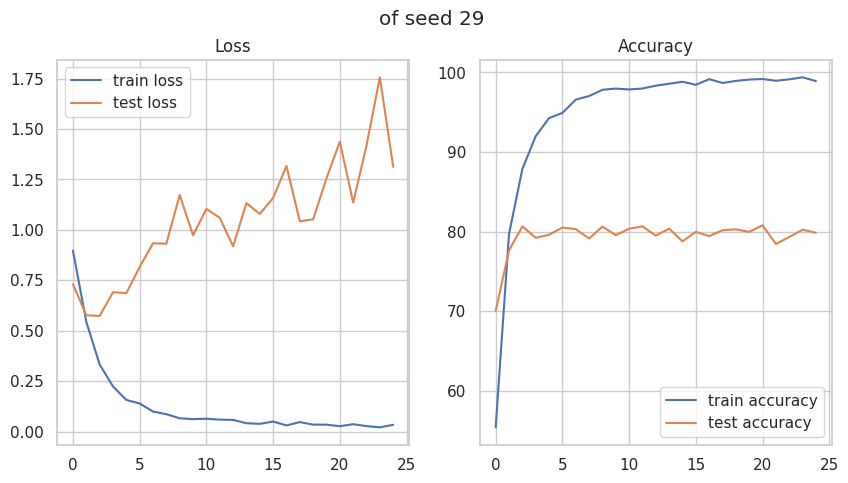

79.864804964539


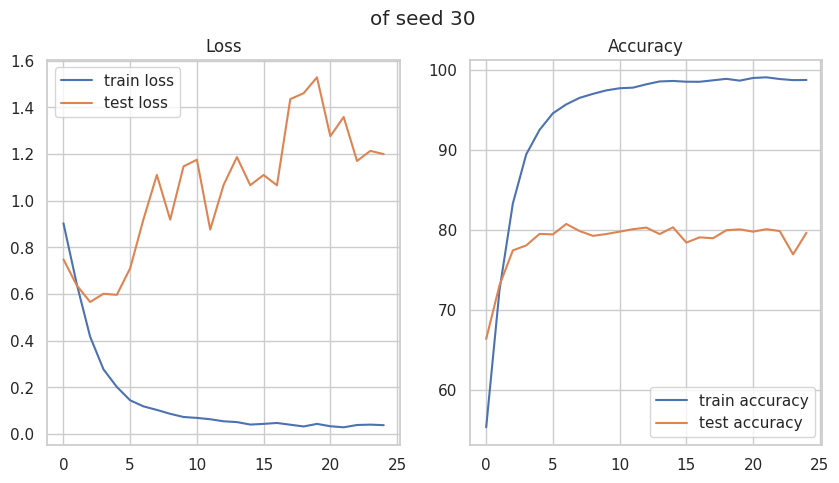

79.66533687943263


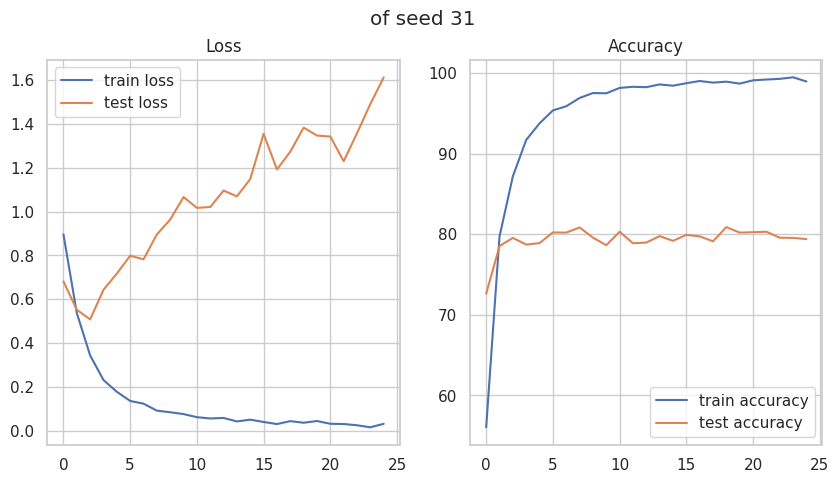

79.38829787234043


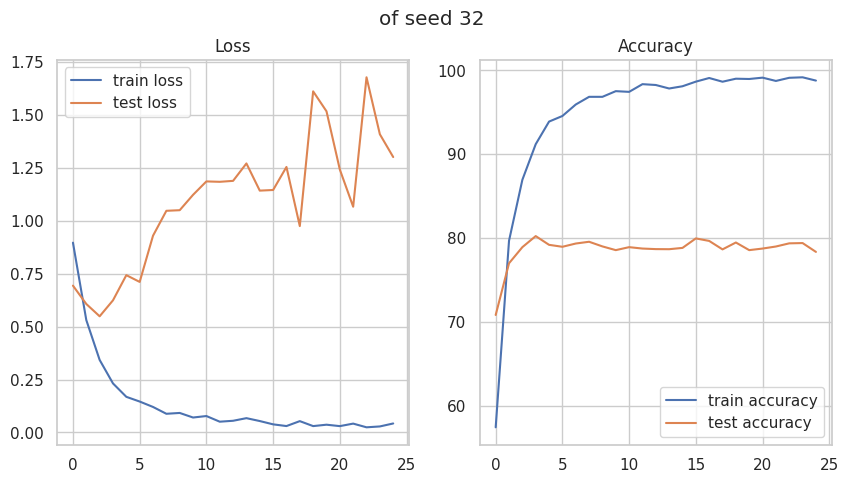

78.36879432624114


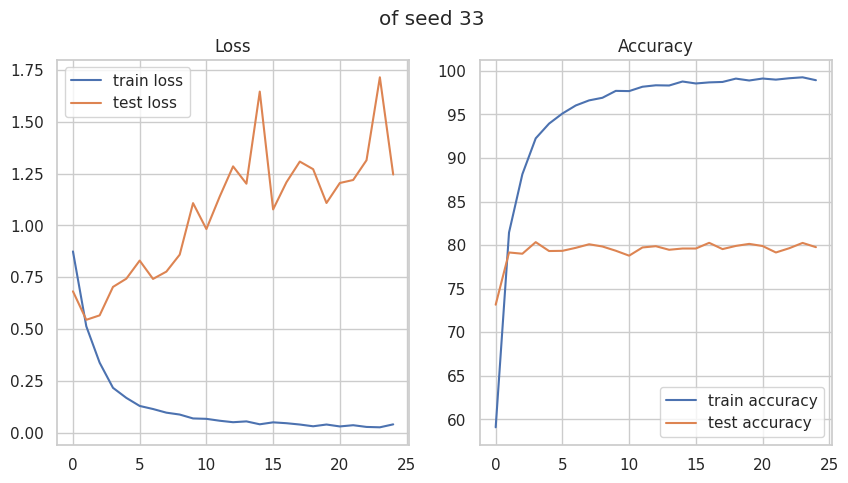

79.76507092198582


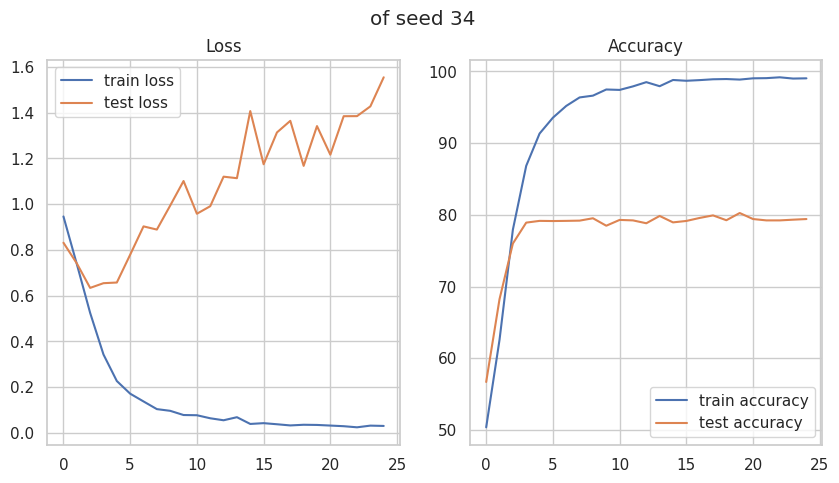

79.4104609929078


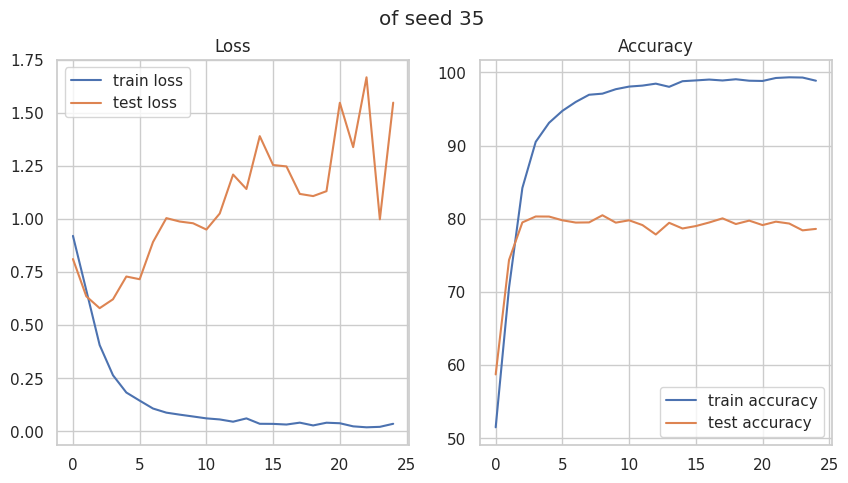

78.62367021276596


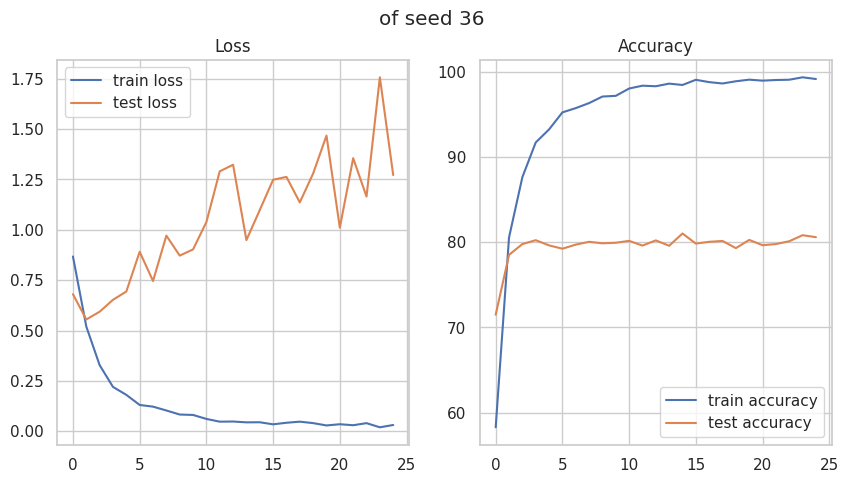

80.59618794326242


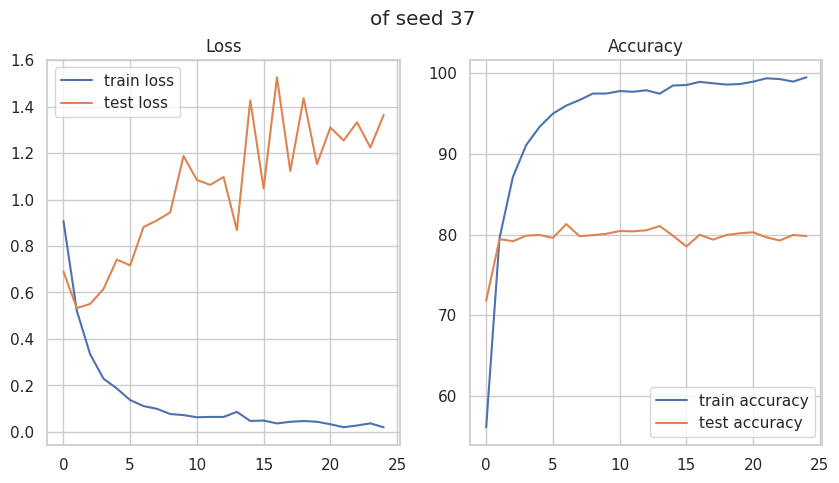

79.80939716312056


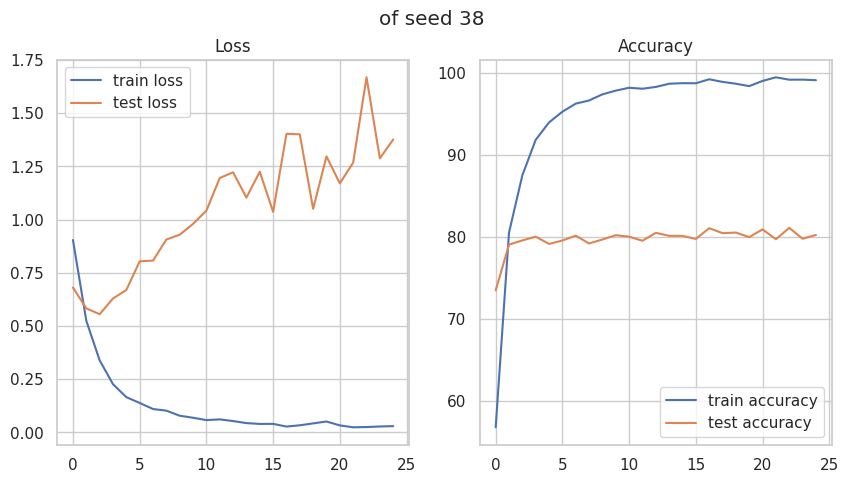

80.20833333333333


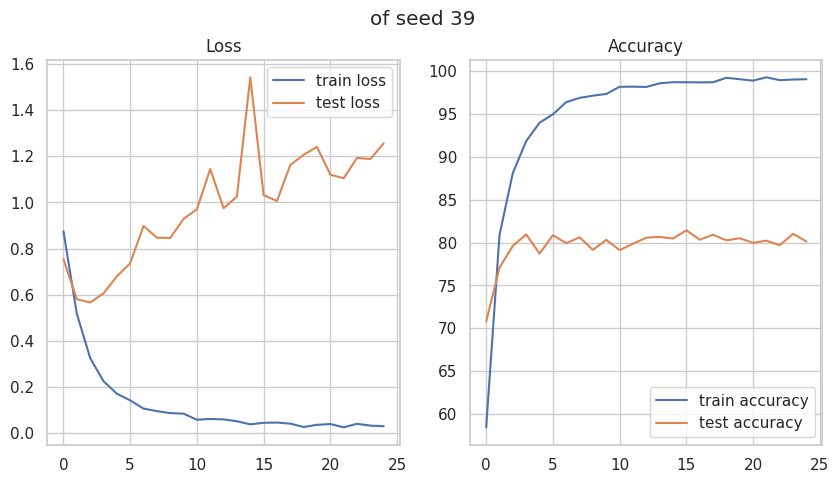

80.13076241134752


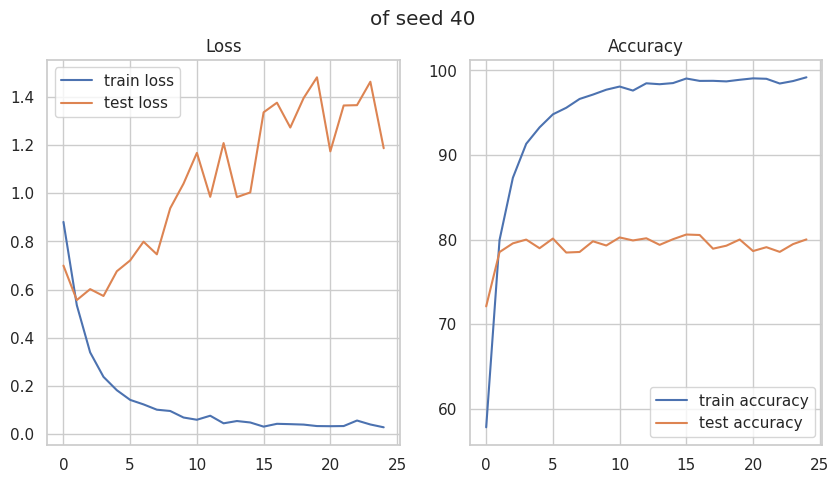

80.01994680851064


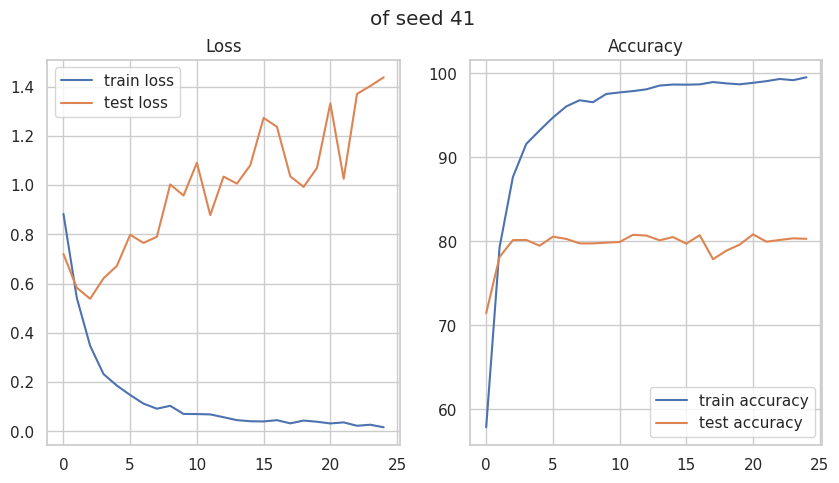

80.29698581560284


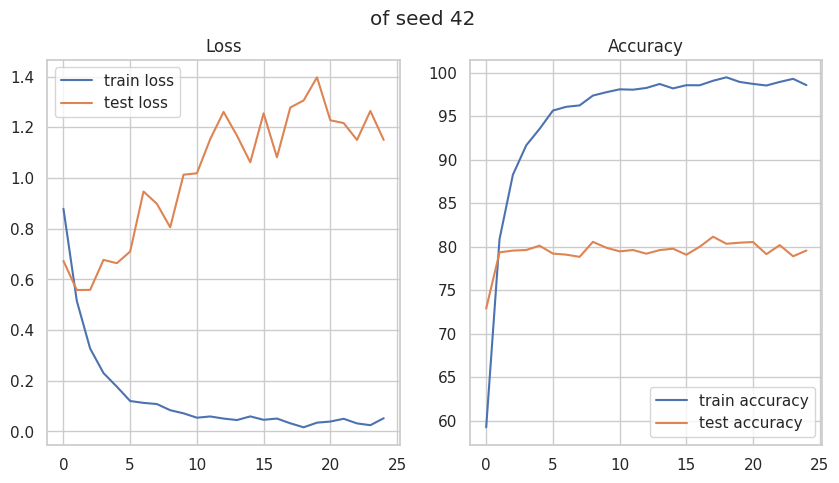

79.56560283687944


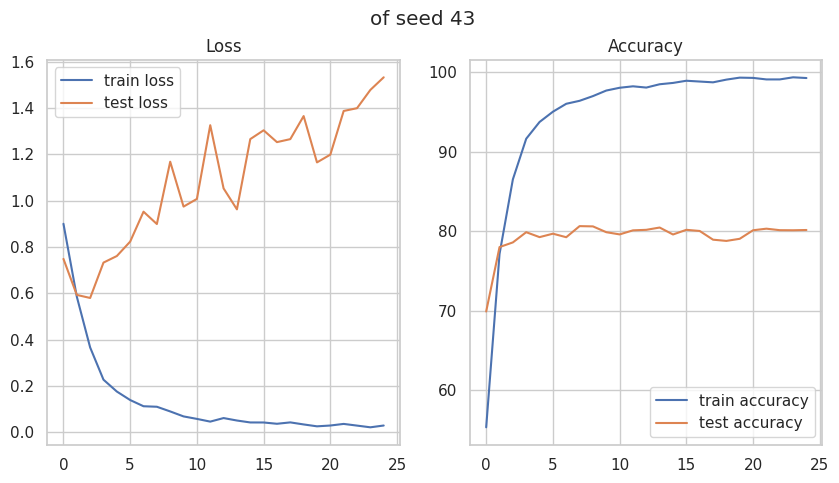

80.1418439716312


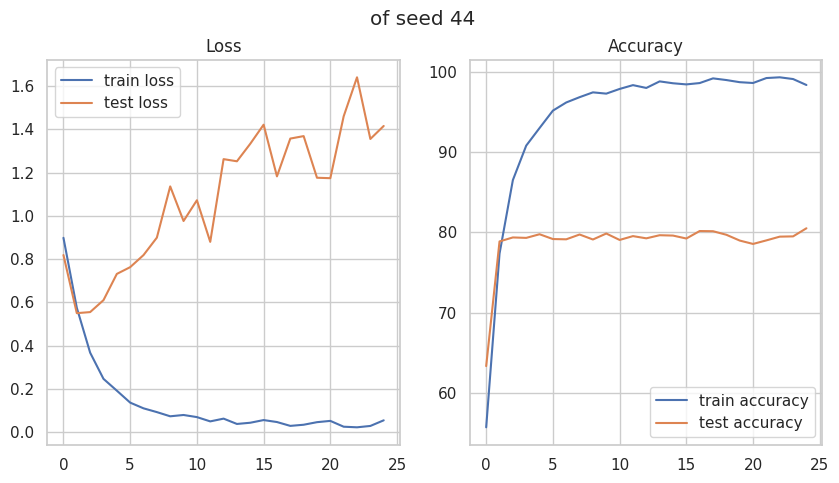

80.49645390070923


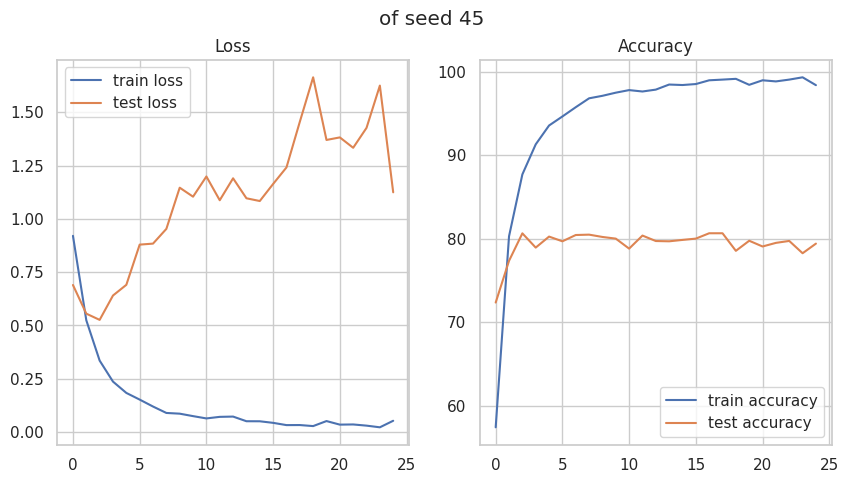

79.39937943262412


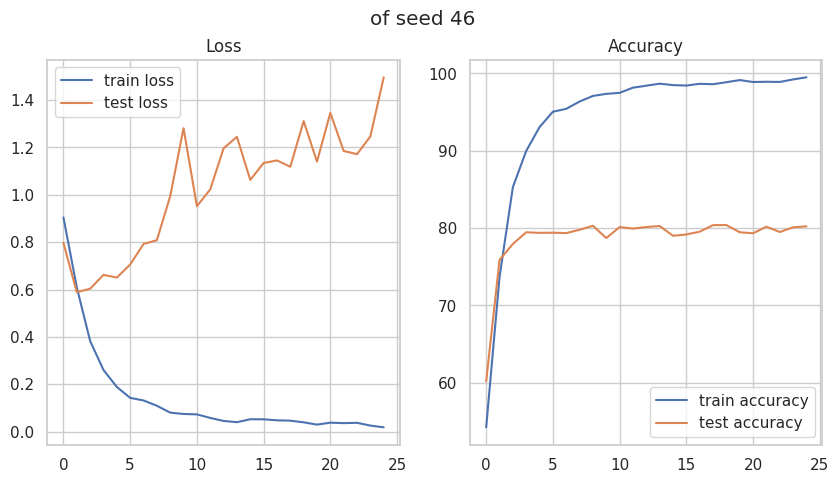

80.21941489361703


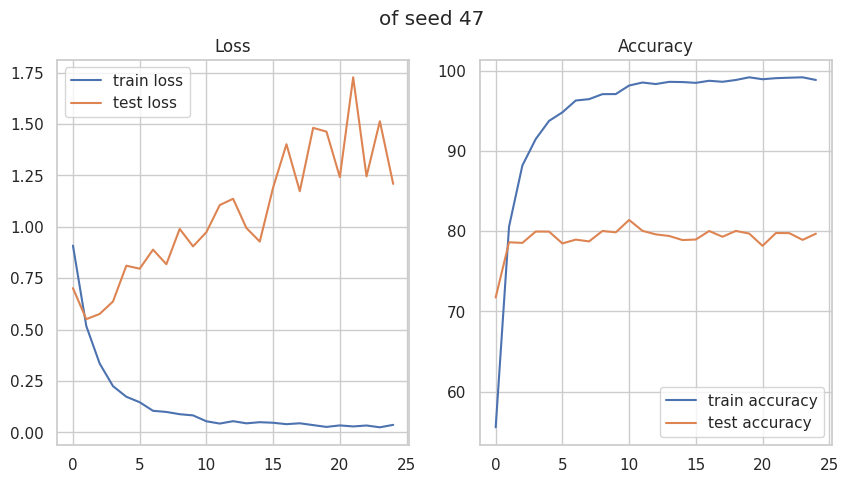

79.6875


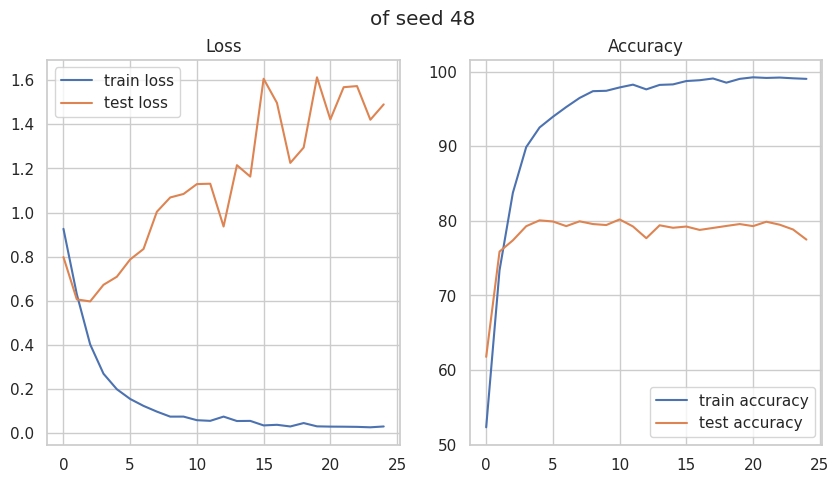

77.48226950354609


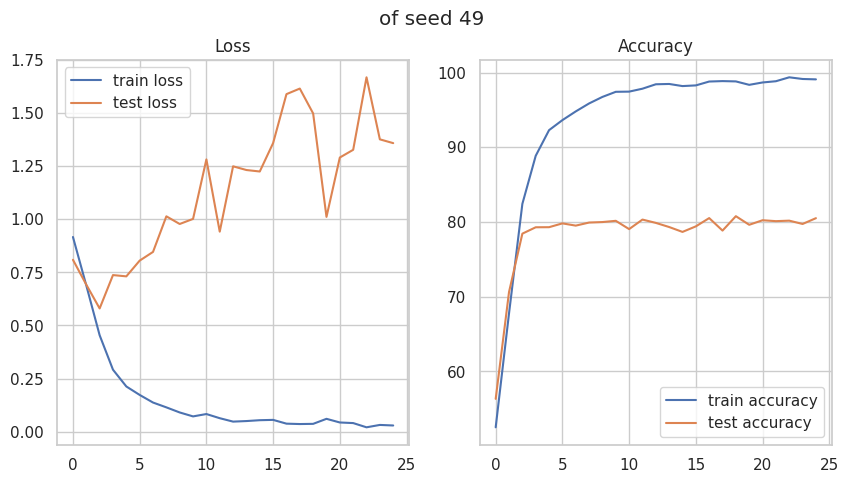

80.5075354609929


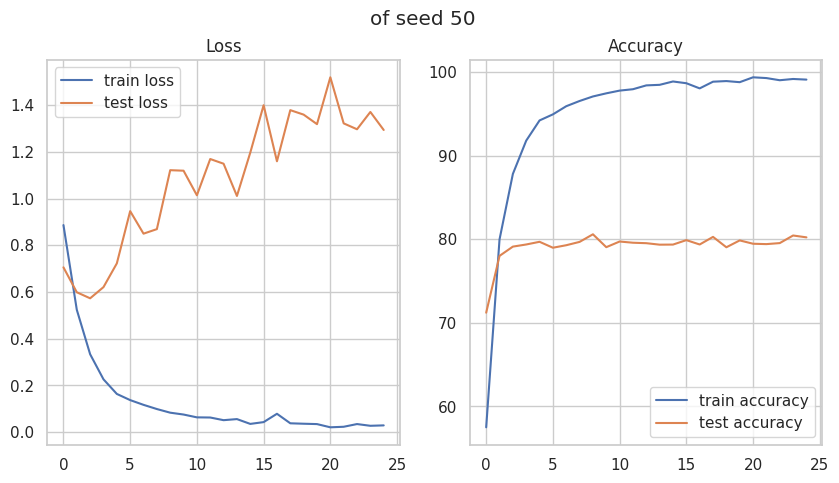

80.23049645390071


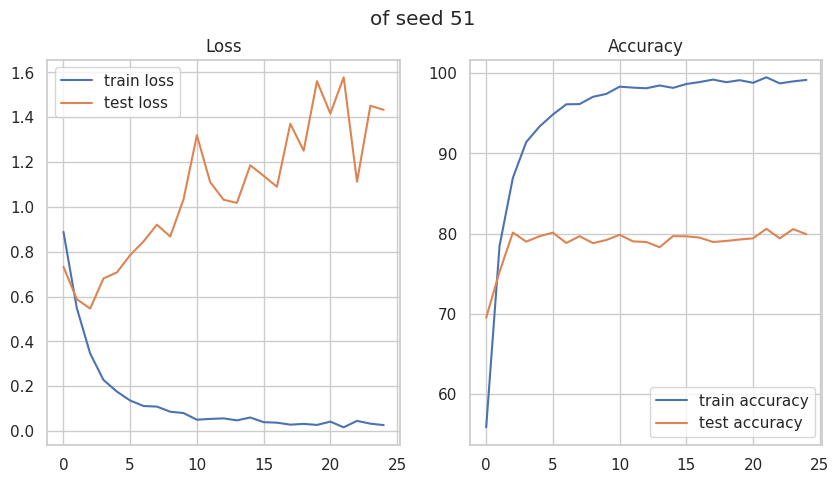

79.93129432624114


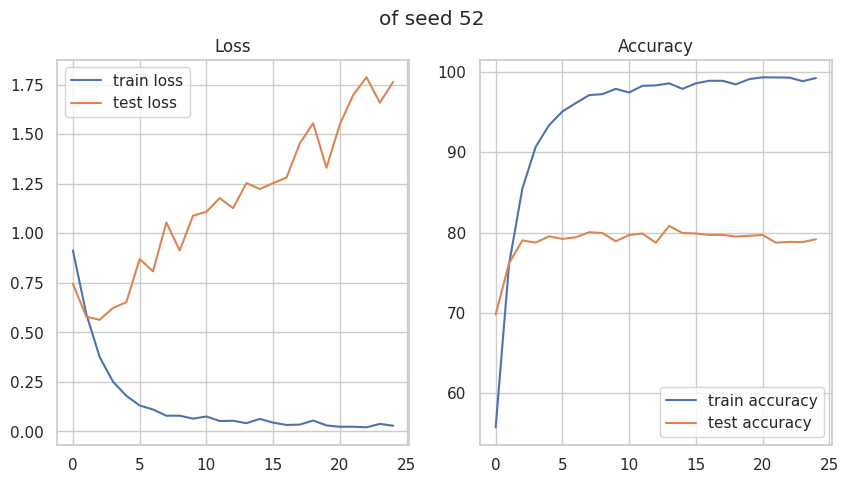

79.15558510638297


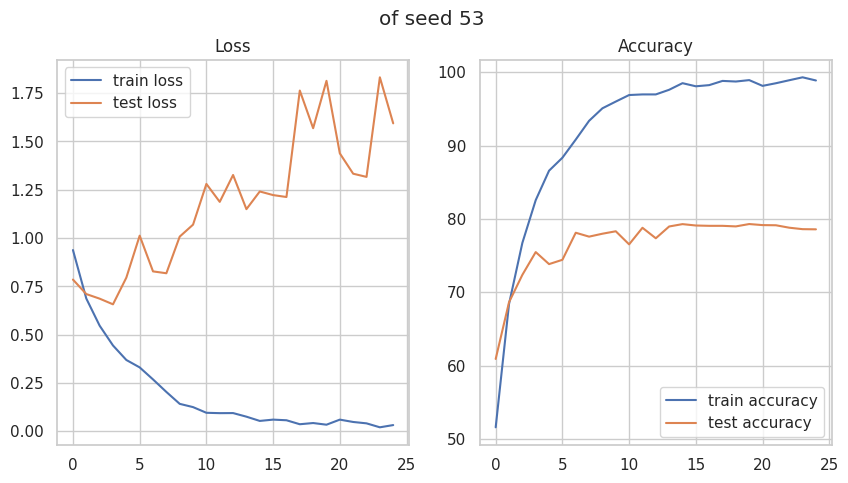

78.5793439716312


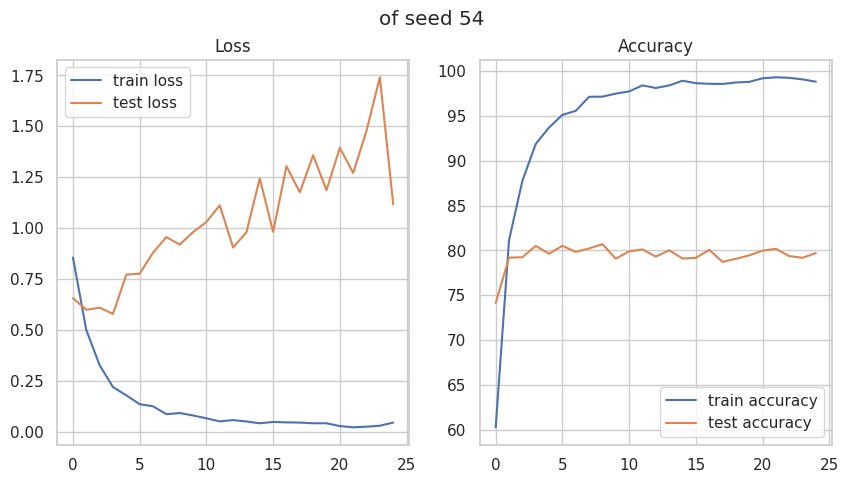

79.69858156028369


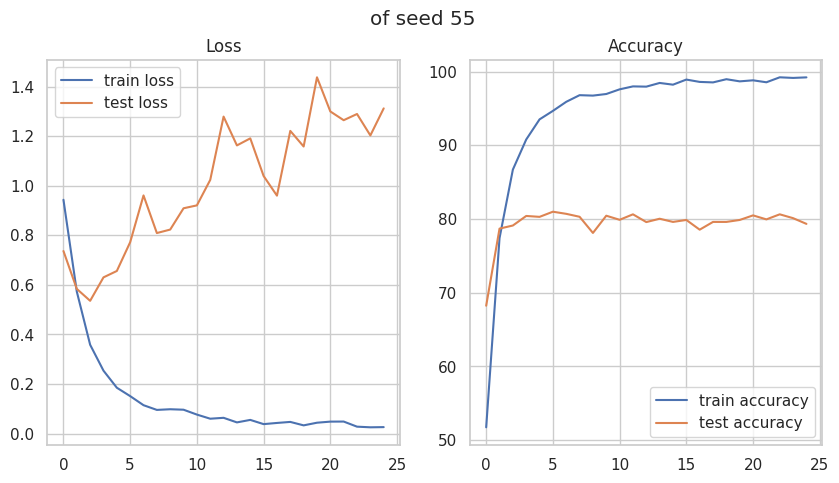

79.33289007092199


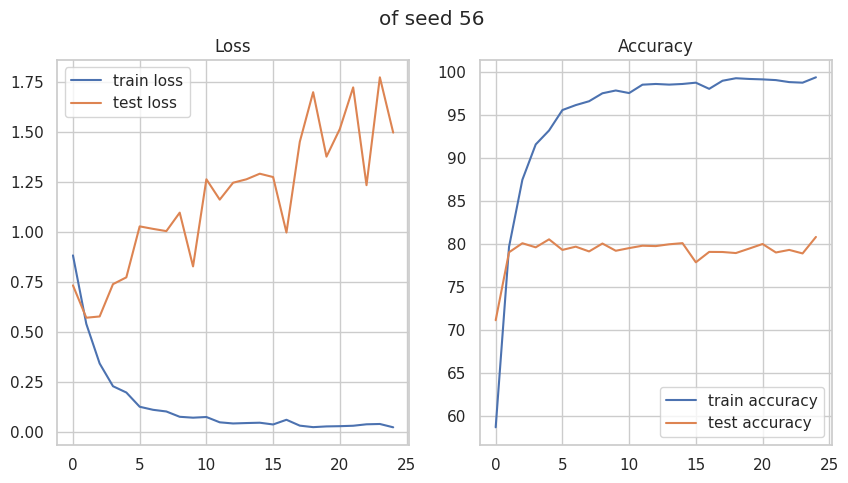

80.83998226950354


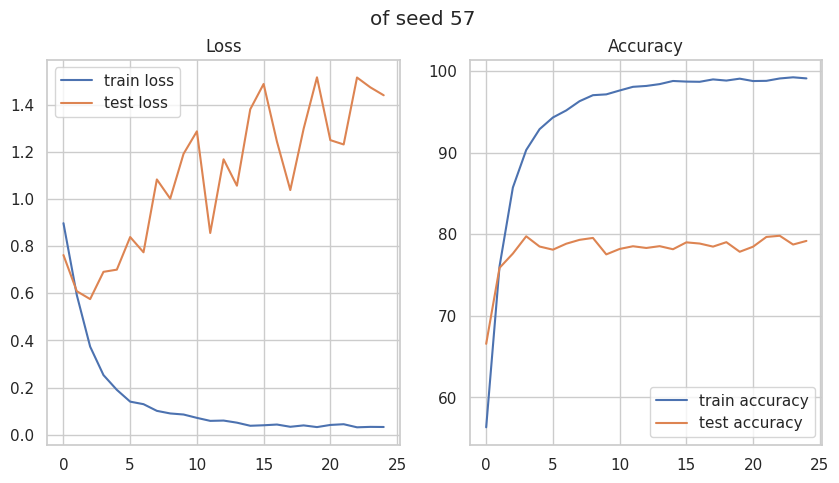

79.16666666666667


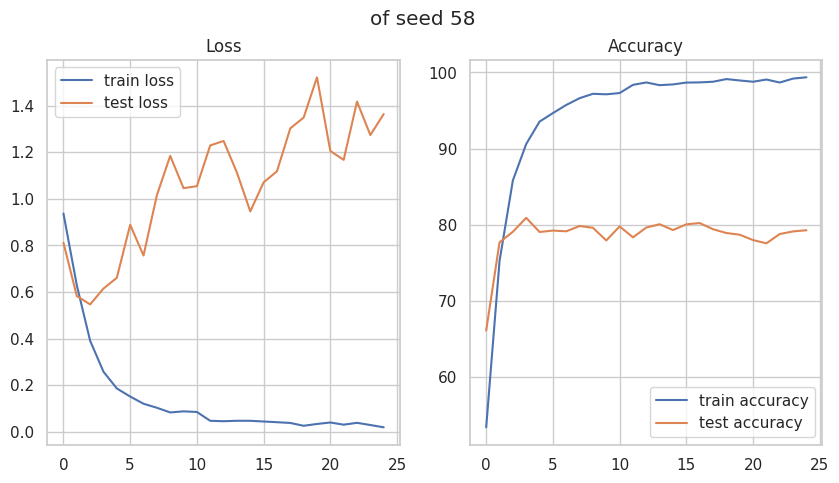

79.27748226950354


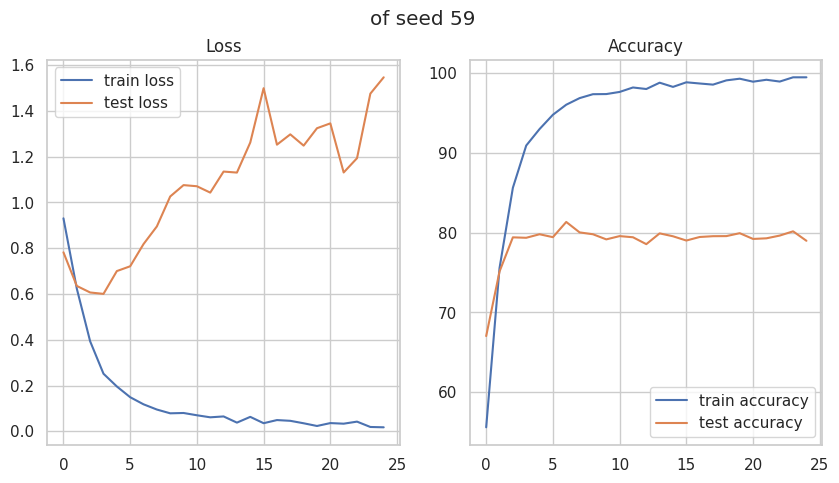

78.96719858156028


In [25]:
accuracy_seed_train,accuracy_seed_test,loss_seed_test,loss_seed_train = [],[],[],[]
import matplotlib.pyplot as plt
for i in range(60):
    q,w,e,r=model_train(train_dataloader, test_dataloader, i)
    loss_seed_train.append(q),loss_seed_test.append(w),accuracy_seed_train.append(e),accuracy_seed_test.append(r)
    # plot q,e as loss and e,r as accuracy  in collage
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'of seed {i}')

    axs[0].plot(q, label='train loss')
    axs[0].plot(w, label='test loss')
    axs[0].legend()
    axs[0].set_title('Loss')
    axs[1].plot(e, label='train accuracy')
    axs[1].plot(r, label='test accuracy')
    axs[1].legend()
    axs[1].set_title('Accuracy')
    plt.show()
    print(r[-1])
    

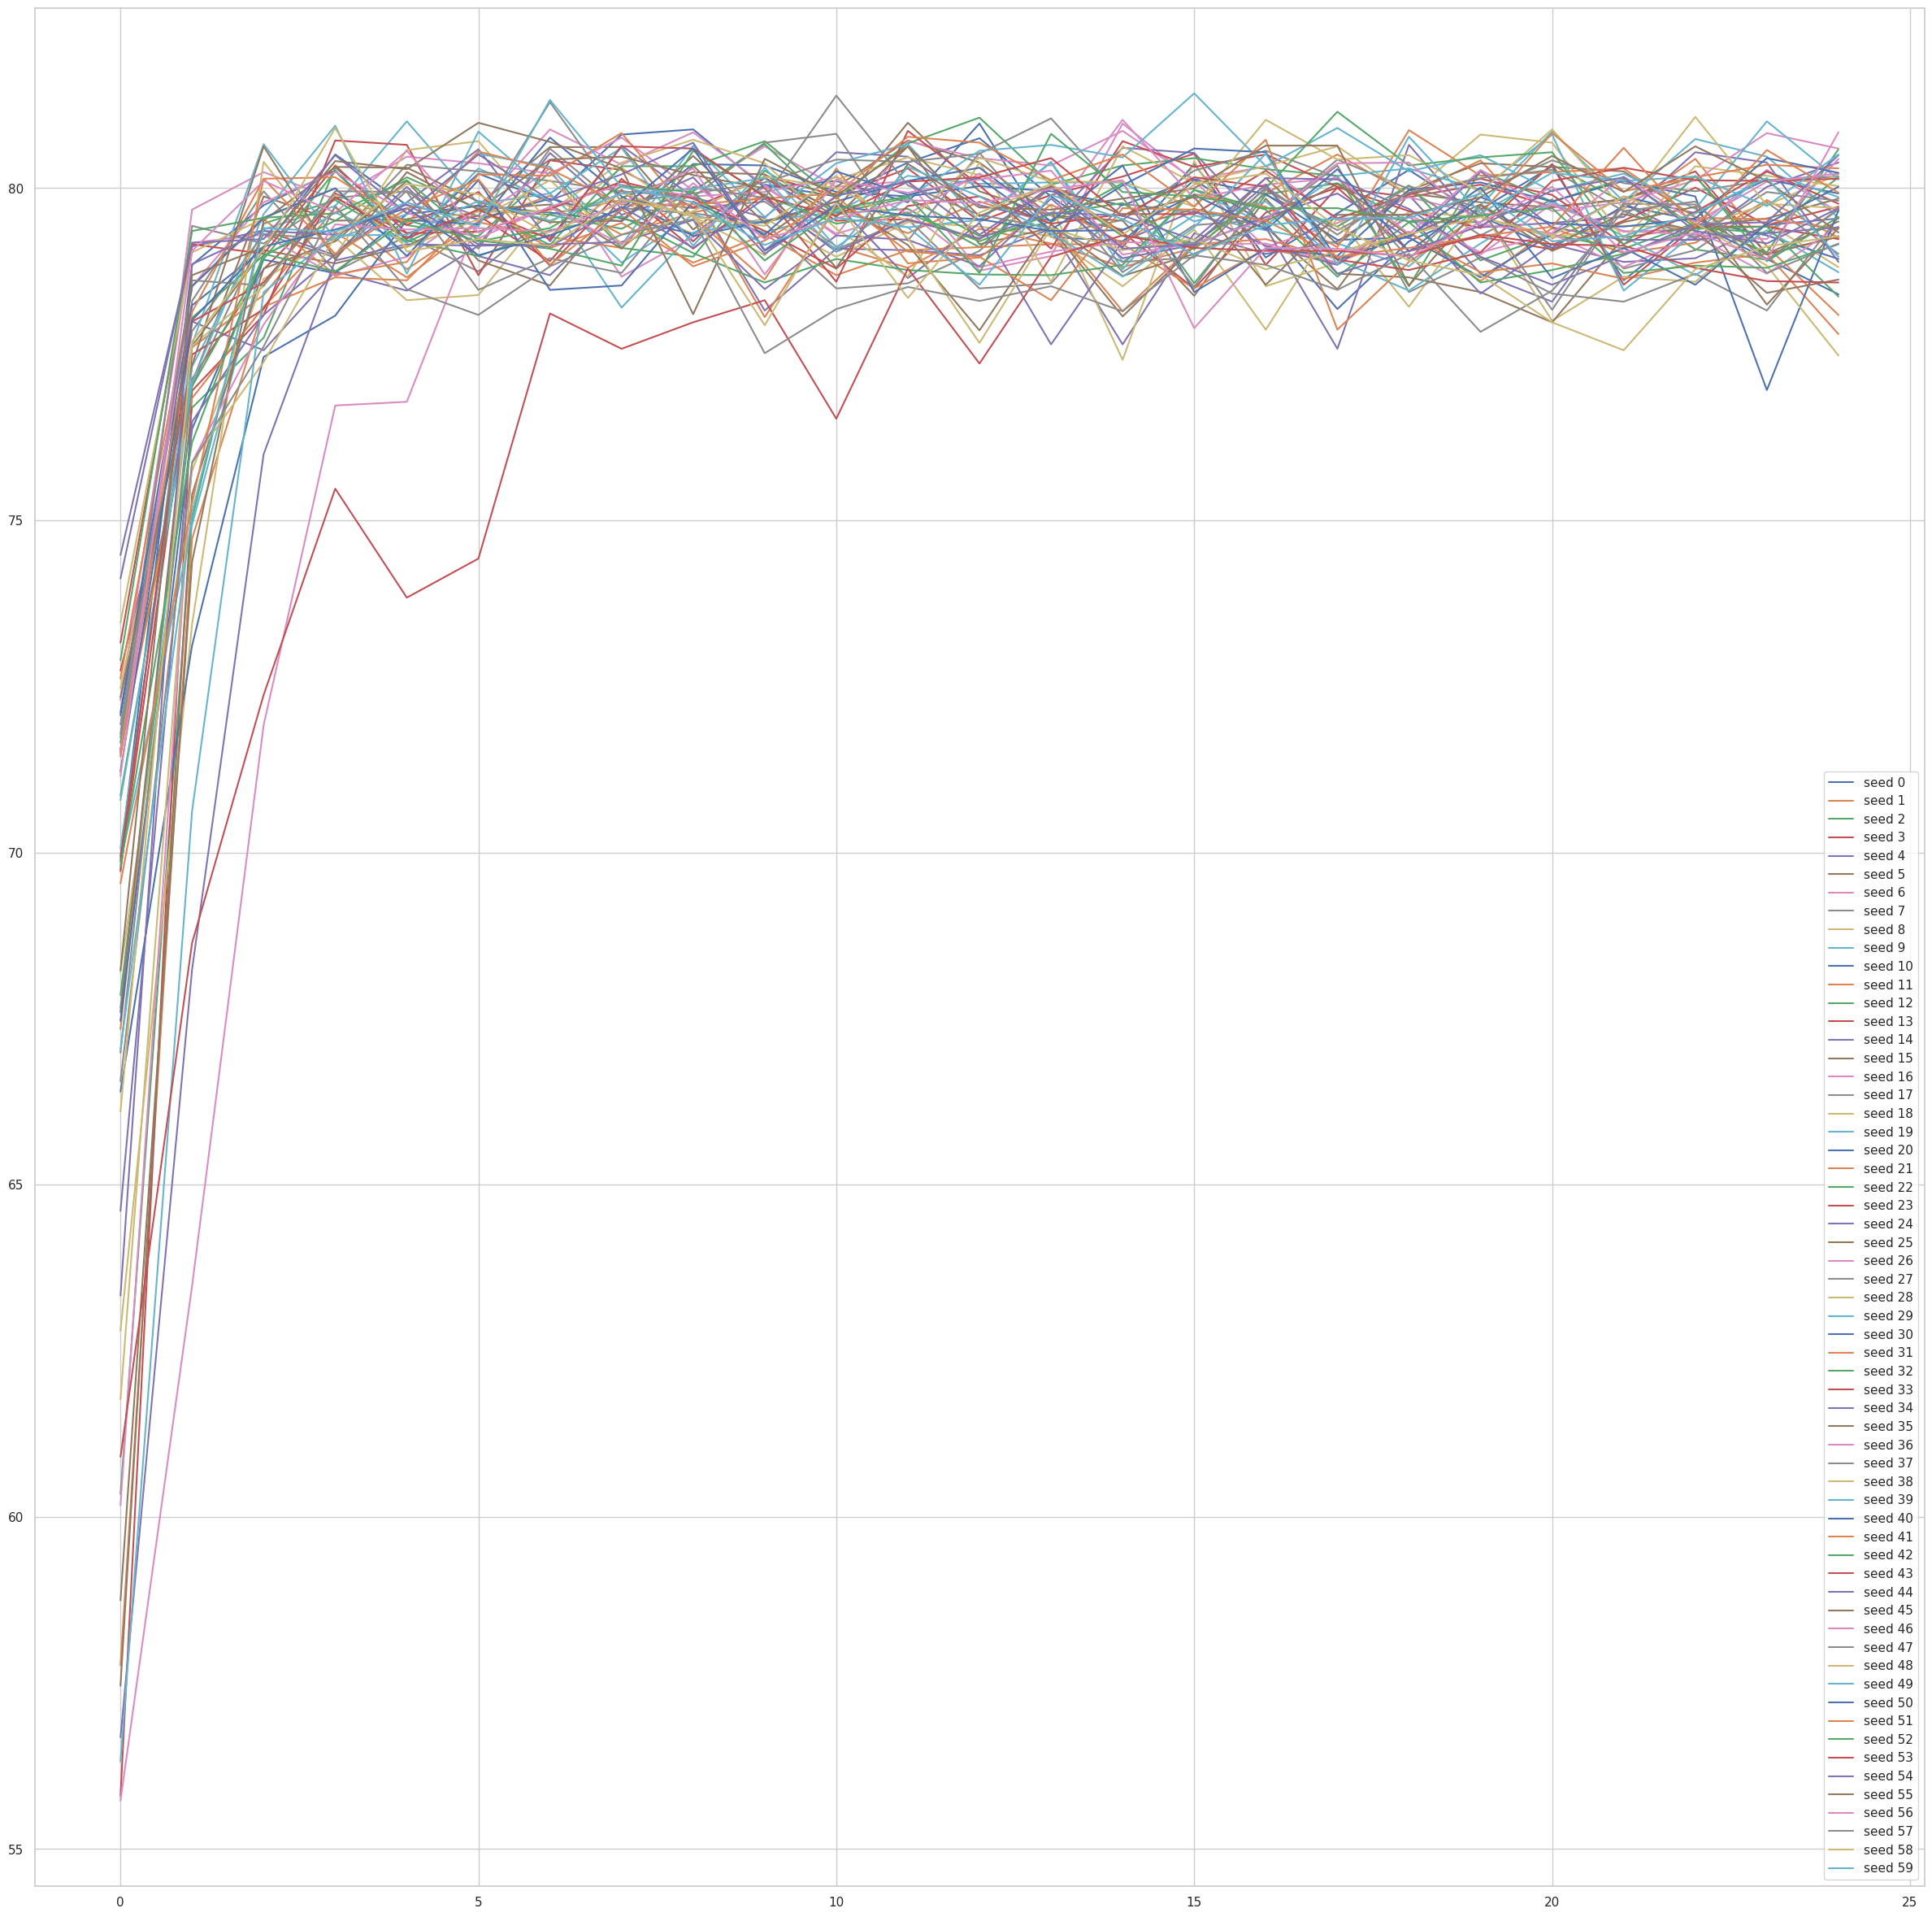

In [26]:
# accuracy_seed_test
fig=plt.figure(figsize=(30,30))
for i in range(60):
    plt.plot(accuracy_seed_test[i], label=f'seed {i}')
plt.legend()

## lahsan


In [27]:
# save all lisst as numpy array
np.save("accuracy_seed_train.npy",accuracy_seed_train)
np.save("accuracy_seed_test.npy",accuracy_seed_test)
np.save("loss_seed_test.npy",loss_seed_test)
np.save("loss_seed_train.npy",loss_seed_train)


In [28]:
# load the numpy array
accuracy_seed_train = np.load("accuracy_seed_train.npy")
accuracy_seed_test = np.load("accuracy_seed_test.npy")
loss_seed_test = np.load("loss_seed_test.npy")
loss_seed_train = np.load("loss_seed_train.npy")

In [29]:
# find max accuracy_seed_test[i][-1] and return the seed
max_acc = 0
max_seed = 0
for i in range(60):
    if accuracy_seed_test[i][-1]>max_acc:
        if accuracy_seed_test[i][-1]>max_acc:
        max_acc = accuracy_seed_test[i][-1]
        max_seed = i
print(f"max accuracy of {max_acc} is at seed {max_seed}")


IndentationError: expected an indented block after 'if' statement on line 6 (853085758.py, line 7)